In [1]:
# %matplotlib notebook

from IPython.display import HTML

HTML('''
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>
''')
import warnings; warnings.simplefilter('ignore')

# Introduction

In this activity, we'll be using satellite imagery to automatically detect objects in the ocean. 

In order to do this, we need to develop a system that will detect water in an image.

# Colour Selection

Our satellite images are colour images. All colour images consist of three components: red, green and blue. The first step is to select which colours (or ratio of colours) we want to work with.

Click on the buttons below to select which colours you want. The image on the left is the original image, while the one on the right is the colour component you selected (note that the individual colour components render in greyscale!) 

Think about the three colours and how they relate to land and water. We want an image that will separate the water from the land as best as possible. But how do we know which one is best?

The histogram graph below shows the frequency of the pixel brightness in the new image. **The best choices will result in a graph with two peaks (a bimodal graph), which correspond to land and water respectively!**   

Once you've made your choice, move on to the next step.

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.color import label2rgb

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import ndimage as ndi
from skimage import data
from skimage import io
from skimage import color
from IPython.display import HTML
import cv2

global image_rgb
global image_hsv
global image
global image_cleaned
global threshold_value
global choice
global big_threshold
global closing_size

closing_size = 20
big_threshold = 500001
choice = "All RGB Bands"
threshold_value = 0
image_rgb = io.imread('34b2f95c3.jpg')
image_hsv = color.convert_colorspace(image_rgb, 'RGB', 'HSV')
image = image_rgb
training_years = range(1984, 2008)
testing_years = range(2008, 2030) 

import warnings
warnings.filterwarnings("ignore")
 
def _select_bands(image_rgb, choice):
    epsilon = 1
    if choice == "All RGB Bands":
        image = color.rgb2grey(image_rgb) * 255
    elif choice == "Red Band":
        image = image_rgb[:, :, 0] * 255
    elif choice == "Green Band":
        image = image_rgb[:, :, 1] * 255
    elif choice == "Blue Band":
        image = image_rgb[:, :, 2] * 255
    elif choice == "All HSV Bands":
        image = color.rgb2grey(image_rgb) * 255
    elif choice == "Hue":
        image = image_rgb[:, :, 0] * 255
    elif choice == "Saturation":
        image = image_rgb[:, :, 1] * 255
    elif choice == "Value":
        image = image_rgb[:, :, 2] * 255
    elif choice == "Red-Green Ratio":
        image = np.log(image_rgb[:, :, 0] / (image_rgb[:, :, 1] + epsilon))
        image = image / image.max() * 255   
    elif choice == "Red-Blue Ratio":
        image = image_rgb[:, :, 0] / (image_rgb[:, :, 2] + epsilon)
        image = image / image.max() * 255   
    elif choice == "Green-Red Ratio":
        image = image_rgb[:, :, 1] / (image_rgb[:, :, 0] + epsilon)
        image = image / image.max() * 255   
    elif choice == "Green-Blue Ratio":
        image = image_rgb[:, :, 1] / (image_rgb[:, :, 2] + epsilon)
        image = image / image.max() * 255   
    elif choice == "Blue-Red Ratio":
        image = image_rgb[:, :, 2] / (image_rgb[:, :, 0] + epsilon)
        image = image / image.max() * 255   
    elif choice == "Blue-Green Ratio":
        image = image_rgb[:, :, 2] / (image_rgb[:, :, 1] + epsilon)
        image = image / image.max() * 255   
    else:
        raise ValueError
    return image
    
    



def segment_image(image_rgb, spectrum, threshold):
    """
    Return the segmented image and area
    """
    im = _select_bands(image_rgb, spectrum)
    clean_im = morphology.remove_small_objects((im < threshold), 50)
    segmentation = ndi.binary_fill_holes(clean_im)
    labeled_image, _ = ndi.label(segmentation)
    image_label_overlay = label2rgb(labeled_image, image=clean_im)
    plt.imshow(im_rgb, cmap=plt.cm.gray, interpolation='nearest')
    plt.contour(segmentation, [0.5], linewidths=1.2, colors='r')
    return plt, image_label_overlay[:,:,1].sum()


def _calculate_area(clean_im):
    segmentation = ndi.binary_fill_holes(clean_im)
    labeled_image, _ = ndi.label(segmentation)
    image_label_overlay = label2rgb(labeled_image, image=clean_im)
    return image_label_overlay[:,:,1].sum()

    

In [3]:
def select_bands(c):
    
    global image
    global image_rgb
    global choice
    choice = c
    image = _select_bands(image_rgb, c)
    

    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.set_title("Original Image")
    ax1.imshow(image_rgb, cmap=plt.cm.gray, interpolation='nearest')
    ax2 = fig.add_subplot(2,2,2)
    ax2.set_title("New Image")
    ax2.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax3 = fig.add_subplot(2,2,3)
    hist = np.histogram(image, bins=np.arange(0, 256))
    ax3.set_title("Histogram")
   
    plt.plot(hist[1][:-1], hist[0], lw=2)
    
    
    #plt.imshow(image_rgb, cmap=plt.cm.gray, interpolation='nearest')
    #plt.show()
    #plt.imshow()
    #plt.show()
    ##hist = np.histogram(image, bins=np.arange(0, 256))
    #plt.plot(hist[1][:-1], hist[0], lw=2)
    #plt.show()


buttons = widgets.ToggleButtons(
    #options=['All Bands', 'Red Band', 'Green Band', 'Blue Band', 'Red-Green Ratio', 'Red-Blue Ratio', 'Green-Red Ratio', 'Green-Blue Ratio','Blue-Red Ratio', 'Blue-Green Ratio'],
    options=['All RGB Bands', 'Red Band', 'Green Band', 'Blue Band'],
    description='Colours:',
    disabled=False,
    selected=2,
    button_style='',
)

interact(select_bands, c=buttons);

interactive(children=(ToggleButtons(description='Colours:', options=('All RGB Bands', 'Red Band', 'Green Band'…

# Thresholding

We now pick which sections of the image are part of the lake, and which are part of the land. Drag the slider to select a value. All pixels with values greater than the threshold will be considered as the lake. Everything else is the land.

**Use the histogram above to select the threshold by picking a value in between the two peaks!**

Try pick the value so the image looks like the shape of the lake (remember that the lake has two islands!). Once you're satisfied, move to the next step. If the thresholding doesn't result in a lake-shaped image, you may have to pick different colours.

In [4]:
def threshold(val):
    global threshold_value
    threshold_value = val
    
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Image after Thresholding")

    ax.imshow(image < val, cmap=plt.cm.gray, interpolation='nearest')
    
    #plt.imshow(image > val, cmap=plt.cm.gray, interpolation='nearest')
    
    
    
    #plt.show()
    #plt.tight_layout()

threshold_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=255,
    step=1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

interact(threshold, val=threshold_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Threshold:', max=255), Output()…

<function __main__.threshold(val)>

# Colour Spaces

Sometimes the RGB colour space doesn't represent the colours in an intuitive way, and it becomes difficult to separate out the objects. We can see from the images above, that regardless of which channel and threshold you pick there will be lots of noise around the objects that we're trying to detect.

Rather than representing images using the additive primary colours (Red-Green-Blue), we can use a different representation called HSV (Hue Saturation Value). The Hue refers to the colour, the saturation refers to the "greyness" and the value refers to the brightness.

<a href="https://commons.wikimedia.org/wiki/File:HSV_color_solid_cylinder.png"><img src="hsv1.png" style="width: 400px;"/></a>

In [5]:
def select_bands_hsv(c):
    
    global image
    global image_rgb
    global image_hsv
    global choice
    choice = c
    image = _select_bands(image_hsv, c)
    

    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.set_title("Original Image")
    ax1.imshow(image_rgb, cmap=plt.cm.gray, interpolation='nearest')
    ax2 = fig.add_subplot(2,2,2)
    ax2.set_title("New Image")
    ax2.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax3 = fig.add_subplot(2,2,3)
    hist = np.histogram(image, bins=np.arange(0, 256))
    ax3.set_title("Histogram")
    ax3.set_ylim(0,2500)
    plt.plot(hist[1][:-1], hist[0], lw=2)
    
    
    #plt.imshow(image_rgb, cmap=plt.cm.gray, interpolation='nearest')
    #plt.show()
    #plt.imshow()
    #plt.show()
    ##hist = np.histogram(image, bins=np.arange(0, 256))
    #plt.plot(hist[1][:-1], hist[0], lw=2)
    #plt.show()


buttons = widgets.ToggleButtons(
    #options=['All Bands', 'Red Band', 'Green Band', 'Blue Band', 'Red-Green Ratio', 'Red-Blue Ratio', 'Green-Red Ratio', 'Green-Blue Ratio','Blue-Red Ratio', 'Blue-Green Ratio'],
    options=['All HSV Bands', 'Hue', 'Saturation', 'Value'],
    description='Colours:',
    disabled=False,
    selected=2,
    button_style='',
)

interact(select_bands_hsv, c=buttons);

interactive(children=(ToggleButtons(description='Colours:', options=('All HSV Bands', 'Hue', 'Saturation', 'Va…

In [6]:
def threshold_hsv(val):
    global threshold_value
    threshold_value = val
    
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Image after Thresholding")

    ax.imshow(image < val, cmap=plt.cm.gray, interpolation='nearest')
    
    #plt.imshow(image > val, cmap=plt.cm.gray, interpolation='nearest')
    
    
    
    #plt.show()
    #plt.tight_layout()

threshold_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=255,
    step=1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

interact(threshold_hsv, val=threshold_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Threshold:', max=255), Output()…

<function __main__.threshold_hsv(val)>

# Remove small holes

There may be small specks in the above image. To remove these artefacts, click on the button below which removes shapes smaller than a certain size. This will clean up the image a bit.

Button(description='Click to clean image', style=ButtonStyle())

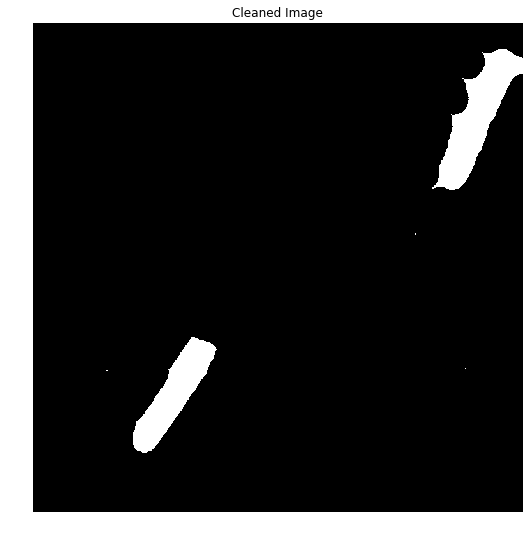

In [7]:
from skimage import morphology
from skimage.morphology import disk

def remove_small_objects(button):
    from IPython import display as dsp
    dsp.clear_output(wait=True)
    display(button)
    global image
    global threshold_value
    global image_cleaned
    global closing_size
    #image_cleaned = morphology.remove_small_objects((image < threshold_value), 50)
    image_cleaned = morphology.closing(image < threshold_value, disk(closing_size))
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Cleaned Image")
    
    # fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image_cleaned, cmap=plt.
              cm.gray, interpolation='nearest')
    ax.axis('off')
    
    #ax.set_adjustable('box-forced')


button1 = widgets.Button(description="Click to clean image")
display(button1)
button1.on_click(remove_small_objects)


# Segmentation

Given the above image, we now find different connected clusters in the image, which we then label with different colours. Looking at the original images, we can expect three clusters: the land, the lake and the islands.

Click on the button below to segment the image into these different classes.

The left image shows the different classes. If everything has gone to plan, the right image should provide a nice outline of the lake.

If you're happy with the outline, move to the next step.


In [8]:
def segment(button, save=False, image_index = None, silent=False):
    from IPython import display as dsp
    if not silent:
        dsp.clear_output(wait=True)
    if button is not None:
        display(button)
    global image
    global image_rgb
    global image_cleaned
    global big_threshold
    small_threshold = 10
    segmentation = ndi.binary_fill_holes(image_cleaned)
    labeled_image, n = ndi.label(segmentation)
    sub = 0
    for i in range(1,n+1):
        s = (labeled_image==i).sum()
        #print("Class %d - %d" % (i,s))
        if s > big_threshold:
            idx = (labeled_image==i)
            labeled_image[idx] = 0
            sub += 1
        if s < small_threshold:
            idx = (labeled_image==i)
            labeled_image[idx] = 0
            sub += 1
    
    n -= sub
    
    image_label_overlay = label2rgb(labeled_image, image=image_cleaned)
    
    if save:
        plt.clf()
        plt.title("%s (%d objects detected)" % (str(image_index), n))
        plt.imshow(image_rgb, cmap=plt.cm.gray, interpolation='nearest')
        plt.contour(labeled_image, [0.5], linewidths=1.2, colors='r')
        fname = "temp_{}.png".format(image_index)
        plt.savefig(fname)  
        return n,fname
    elif not silent:
        fig = plt.figure(figsize=(12, 10))
        ax1 = fig.add_subplot(1,2,2)

        ax1.imshow(image_rgb, cmap=plt.cm.gray, interpolation='nearest')
        ax1.contour(labeled_image, [0.5], linewidths=1.2, colors='r')
        ax1.set_title("Contour Overlay")

        ax2 = fig.add_subplot(1,2,1)
        ax2.imshow(labeled_image, interpolation='nearest')
        ax2.set_title("Segmentation")
        #plt.show()
        #plt.imshow(image_label_overlay, interpolation='nearest')
        plt.tight_layout()
        print("Number of objects detected: %d" % (n))
        
    return n
    
    
button2 = widgets.Button(description="Click to segment")
display(button2)
button2.on_click(segment)


Button(description='Click to segment', style=ButtonStyle())

# More Images

Hopefully the settings that you have selected above provide good results. So let's try to apply these settings to some more images!


In [9]:
def apply_to_image(filename, button):
    global image_rgb
    global image_hsv
    global image
    global image_cleaned
    
    image_rgb = io.imread(filename)
    image_hsv = color.convert_colorspace(image_rgb, 'RGB', 'HSV')

    if choice in ('Red','Green','Blue','All RGB Bands'):
        image = _select_bands(image_rgb, choice)
    else:
        image = _select_bands(image_hsv, choice)

    image_cleaned = morphology.closing(image < threshold_value, disk(10))
    segment(None)
    display(button)
    

def apply_image1(button):
    apply_to_image('b3e7f584b.jpg', button)

def apply_image2(button):
    apply_to_image('667f66910.jpg', button)

def apply_image4(button):
    apply_to_image('7ceb4bba7.jpg',button)      
    
def apply_image3(button):
    apply_to_image('37a908fa1.jpg',button)    
    
    

button3 = widgets.Button(description="Segment Image 1")
display(button3)
button3.on_click(apply_image1)

Button(description='Segment Image 1', style=ButtonStyle())

In [10]:
button4 = widgets.Button(description="Segment Image 2")
display(button4)
button4.on_click(apply_image2)

Button(description='Segment Image 2', style=ButtonStyle())

# Land Removal

In images that have larges sections of land, our system will detect the land as a very large object. We know that we're actually looking for aeroplane debris that's a lot smaller, and so we can throw away these very large detected objects.



In [11]:
def threshold_size(val):
    global big_threshold
    global image_cleaned
    if val >= 500000:
        return
    big_threshold = val
    image_cleaned = morphology.closing(image < threshold_value, disk(10))
    segment(None)
    #fig = plt.figure(figsize=(9, 9))
    #ax = fig.add_subplot(1,1,1)
    #ax.set_title("Image after Object Size Thresholding")

    #ax.imshow(image < val, cmap=plt.cm.gray, interpolation='nearest')
    
    #plt.imshow(image > val, cmap=plt.cm.gray, interpolation='nearest')
    
    
    
    #plt.show()
    #plt.tight_layout()

big_threshold_slider = widgets.IntSlider(
    value=500001,
    min=0,
    max=500000,
    step=25000,
    description='Size Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

interact(threshold_size, val=big_threshold_slider)

interactive(children=(IntSlider(value=500000, continuous_update=False, description='Size Threshold:', max=5000…

<function __main__.threshold_size(val)>

# Apply to Multiple Images

We have satellite images from a number of different areas of the ocean. So let's apply your colour choice and thresholding to these images too. Click on the button to generate an animation of these images. Be careful! What worked for the first image may not work for the rest of them! If you're happy with the result, move to the final step. Otherwise, go back and change your colour or threshold choice. 

In [12]:
from matplotlib import animation  
import matplotlib.image as mgimg
import imageio
from IPython.display import Image

def apply_to_image_animation(filename, button, save_output=True, silent=False):
    global image_rgb
    global image_hsv
    global image
    global image_cleaned
    global choice
    global threshold_value
    global big_threshold
    global closing_size
    
    image_rgb = io.imread(filename)
    image_hsv = color.convert_colorspace(image_rgb, 'RGB', 'HSV')

    if choice in ('Red','Green','Blue','All RGB Bands'):
        image = _select_bands(image_rgb, choice)
    else:
        image = _select_bands(image_hsv, choice)

    image_cleaned = morphology.closing(image < threshold_value, disk(closing_size))
    
    if save_output:
        (n,fname) = segment(None, save=True, image_index=filename)
        display(button)
        return (n, fname)
    else:
        n = segment(None, save=False, image_index=filename, silent=silent)
        return n

def build_animation(button):
    
    from IPython import display as dsp
    dsp.clear_output(wait=True)
    display(button)
    
    
    progress = widgets.IntProgress(
    value=0,
    min=0,
    max=24 + 1,
    step=1,
    description='Building:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
    )
    display(progress)
    
    
    #from IPython import display as dsp
    #dsp.clear_output(wait=True)
    #display(button)
        
    # segment_image(1984)
    #from IPython import display as dsp
    #dsp.clear_output(wait=True)
    #interact(segment_image, year=year_slider)
    files = []
    sum_objects = 0
    sum_pictures = 0
    images= ["1fbc5de57.jpg","37a908fa1.jpg","7ceb4bba7.jpg","34b2f95c3.jpg","667f66910.jpg","b3e7f584b.jpg","ba78ed889.jpg"]
    for i in images:
        n, fname = apply_to_image_animation(i, button)
        files.append(fname)
        progress.value += 1
        sum_objects += n
        sum_pictures += (n > 0)
    
    imageio.mimsave('temp.gif', [imageio.imread(f) for f in files], 'GIF', duration=1)
    progress.value += 1
    display(Image(filename='temp.gif', width=750, height=500))
    #ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat_delay=1000)
    #plt.show()
    plt.clf()

button3 = widgets.Button(description="Build Animation")
display(button3)

button3.on_click(build_animation)



Button(description='Build Animation', style=ButtonStyle())

# Accuracy on unseen images

Now that we believe our system is working properly, we will run it on 30 areas where we have taken satellite images. Click the button below to run your code on all the images from the search party.

Be patient while the system processes all the images based on the method and parameters that you have chosen above. This could take up to 3 minutes to finish. Once it has completed, feel free to go back and change your paramters to see whether you can do better when helping the search party.

In [13]:
f = open('test-images/testing.txt')
testing_lines = f.readlines()

def finaltest(button):
    global threshold_value
    global big_threshold
    
    print("File\t\t\tObjectsDetected\t\tActualObjects\tCheckImage\tCorrectObjects")
    i = 0
    n_should_check = 0
    
    n_tp = 0
    n_fp = 0
    n_tn = 0
    n_fn = 0
    
    n_total_objects     = 0
    n_missed_objects    = 0
    n_found_objects     = 0
    n_imaginary_objects = 0
    max = 20
    for t in testing_lines:            
        l = t.split(',')
        filename,numobjects = (l[0],int(l[1]))
        n = apply_to_image_animation("test-images/" + filename, None, save_output=False, silent=True)
        shouldcheck = "No"
        if n > 0 and numobjects > 0:
            # Image should be checked, and is (correct) - TP
            n_tp += 1
            n_should_check += 1
            shouldcheck = "Yes"
        elif n > 0 and numobjects == 0:
            # Image shouldn't be checked, but is - FP
            n_fp += 1
            n_should_check += 1
            shouldcheck = "Yes"
        elif n == 0 and numobjects > 0:
            # Image won't be checkede, but should - FN
            n_fn += 1
            shouldcheck = "No"
        elif n == 0 and numobjects == 0:
            # Image shouldn't be checked and isn't - TN
            n_tn += 1
            shouldcheck = "No"
        
        n_total_objects += numobjects
        if   n == numobjects:
            correct = "Yes"
            n_found_objects += n
        elif n > numobjects:
            correct = "No"
            n_found_objects += numobjects
            n_imaginary_objects += (n-numobjects)
        elif n < numobjects:
            correct = "No"
            n_found_objects += n
            n_missed_objects += numobjects - n
            
            
        print("[%2d/%d] %s\t%d\t\t\t%d\t\t%s\t\t%s" % (i+1,max,filename, n, numobjects,shouldcheck,correct))
        i +=1
        if i == max:
            break
        
    acc = 0.3
    print("\n\nYou told search parties to check %2d areas and skip %2d areas." % (n_tp + n_fp, n_tn + n_fn))
    print("✓\tSearch parties correctly checked %2d areas that actually had objects (correct)." % (n_tp))
    print("✓\tSearch parties correctly skipped %2d areas that did not have objects (saved time)." % (n_tn))
    print("✗\tSearch parties incorrectly checked %2d areas that did not have objects (wasted time)." % (n_fp))
    print("✗\tSearch parties incorrectly skipped %2d areas that actually had objects (potentially missed survivors)." % (n_fp))
    print("You correctly classified %3.2f%% of the areas." % ((n_tp+n_tn)/(n_tp+n_fp+n_tn+n_fn)*100))
    
    print("\n✓\tYou correctly found %d objects out of %d." % (n_found_objects,n_total_objects))
    print("✗\tYou missed %d objects." % (n_missed_objects))
    print("✗\tYou identified %d objects that weren't there." % (n_imaginary_objects)) 
    
    print("\nYou used the following settings:\n\tChannel: %s, Threshold: %d, ObjectSizeThreshold: %d" % (choice,threshold_value,big_threshold))
    
    
button_test = widgets.Button(description="Test on large dataset")
display(button_test)
button_test.on_click(finaltest)


Button(description='Test on large dataset', style=ButtonStyle())

# Congrats!

You've just used machine learning to building an object detection model on satellite imagery that can be used to speed up the search for the survivors! :)

In [14]:

HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
You can toggle the code on and off by clicking <a href="javascript:code_toggle()">here</a>.''')